# Exercise 09 - Object Detection with YOLO

This notebook introduces object detection with the YOLO model, which is described in the papers [Redmon et al., 2016](https://arxiv.org/abs/1506.02640) and [Redmon and Farhadi, 2016](https://arxiv.org/abs/1612.08242). But please note that there have been quite a few versions of YOLO proposed in recent years. So, there are newer and more powerful versions of YOLO than the one used in this notebook.

In this notebook, we focus on the task of object detection in street view images that have been taken with a vehicle mounted camera system. This camera system takes images of the road ahead every few seconds while driving. All images are stored in a folder and have been labelled by drawing bounding boxes around every car and other objects of interest. We then use the "You Only Look Once" (YOLO) network to perform object detection, or more specifically road object detection (cars, traffic lights). Because the YOLO model is very computationally expensive to train, we will not train the model ourselves, but load pre-trained weights to use. 

**Learning objectives:**
- Learn more about the YOLO neural network architecture
- Get to know an easy to use implementation of YOLO
- Use object detection on a car detection dataset
- Understand the output of YOLO

**Before you start, find a GPU on the system that is not heavily used by other users (with **nvidia-smi**), and change X to the id of this GPU.**

**YOLO needs a lot of GPU memory. If the notebook does not work on a certain GPU, then try a GPU with 16GB of memory.**

In [1]:
# Change X to the GPU number you want to use,
# otherwise you will get a Python error
# e.g. USE_GPU = 7
USE_GPU = 7

In [2]:
# Import TensorFlow 
import tensorflow as tf

# Print the installed TensorFlow version
print(f'TensorFlow version: {tf.__version__}\n')

# Get all GPU devices on this server
gpu_devices = tf.config.list_physical_devices('GPU')

# Print the name and the type of all GPU devices
print('Available GPU Devices:')
for gpu in gpu_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set only the GPU specified as USE_GPU to be visible
tf.config.set_visible_devices(gpu_devices[USE_GPU], 'GPU')

# Get all visible GPU  devices on this server
visible_devices = tf.config.get_visible_devices('GPU')

# Print the name and the type of all visible GPU devices
print('\nVisible GPU Devices:')
for gpu in visible_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set the visible device(s) to not allocate all available memory at once,
# but rather let the memory grow whenever needed
for gpu in visible_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

2024-01-21 17:48:08.632870: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 17:48:09.433675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.12.0

Available GPU Devices:
  /physical_device:GPU:0 GPU
  /physical_device:GPU:1 GPU
  /physical_device:GPU:2 GPU
  /physical_device:GPU:3 GPU
  /physical_device:GPU:4 GPU
  /physical_device:GPU:5 GPU
  /physical_device:GPU:6 GPU
  /physical_device:GPU:7 GPU

Visible GPU Devices:
  /physical_device:GPU:7 GPU


## You Only Look Once (YOLO)

"You Only Look Once" (YOLO) is a popular neural network, because it achieves high accuracy while also being able to run in real-time. This algorithm processed images in just one forward pass through the network to make predictions. After non-max suppression, it then outputs the recognized objects together with the bounding boxes.

**Inputs and outputs:**
- The **input** is a batch of m images, and each image has the shape $(608, 608, 3)$, which results in a tensor of shape $(m, 608, 608, 3)$.
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by six numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained below.

**Bounding boxes:**
- The following image gives an example of such a bounding boxes, which is defined by its center coordinates ($b_{x}$, $b_{y}$) and its height and width ($b_{h}$, $b_{w}$). Besides the bounding box itself, a neural network should predict a confidence value ($p_{c}$) (probability) that an object is within the bounding box, and the class $c$. If there are 80 classes that the object detector recognizes, the class labels $c$ can be represented either as an integer from 1 to 80, or as an 80-dimensional one-hot encoded vector (with zeroes and one) resulting in a vector of 85 numbers.

<center>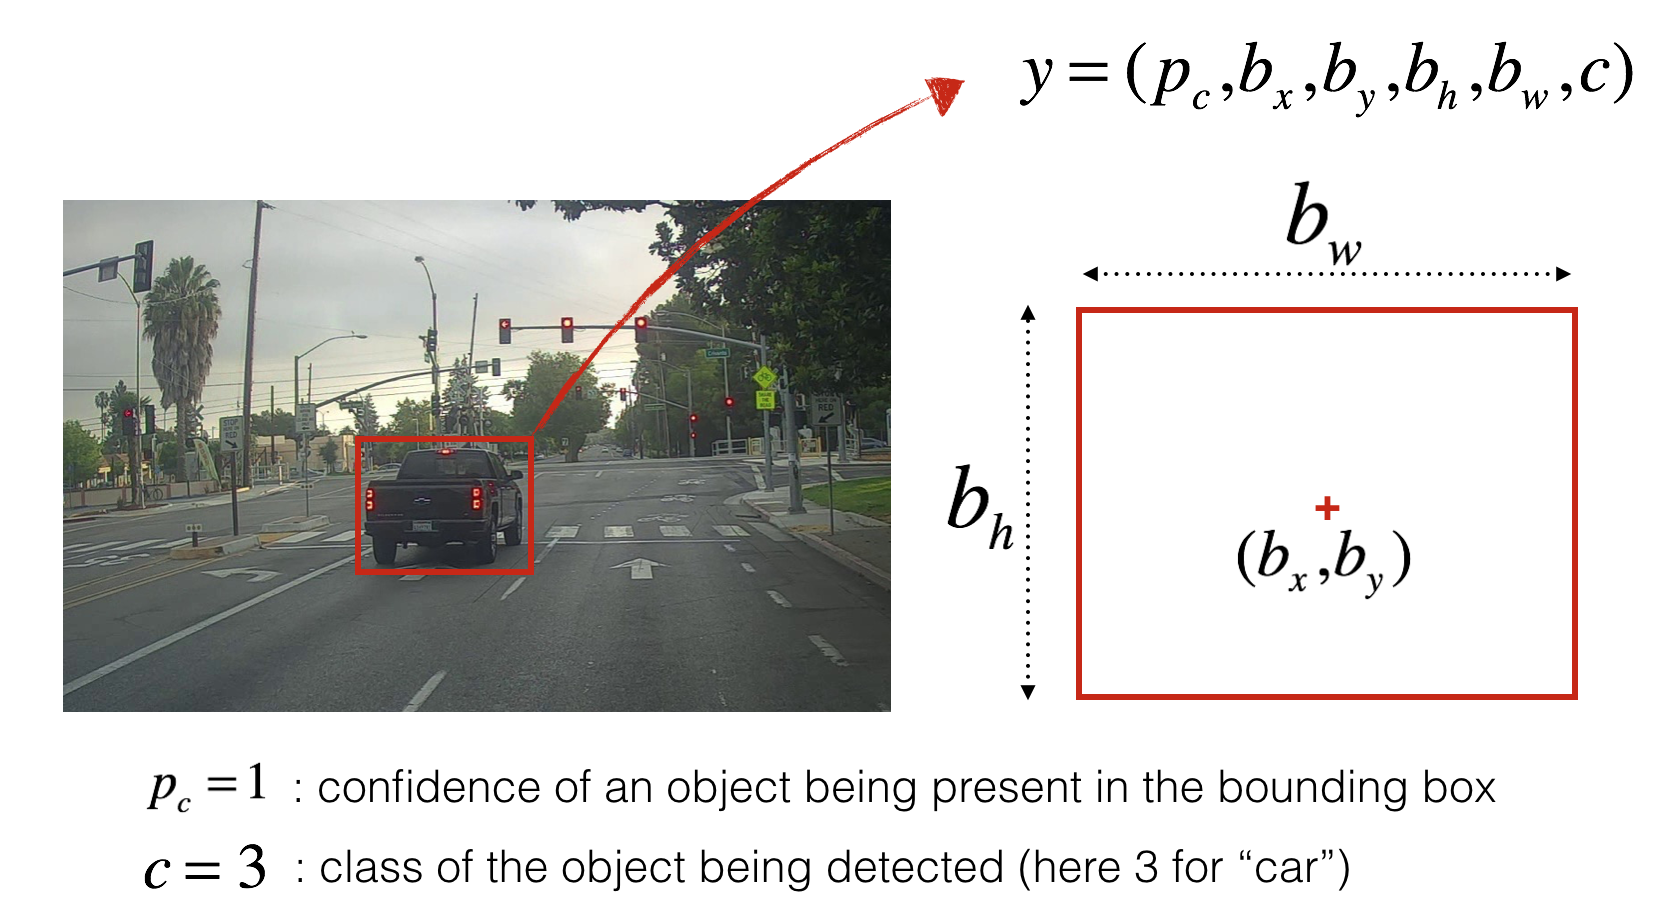</center>

**Anchor boxes:**
- After feature encoding, YOLO assumes at each feature map cell a number of anchor boxes in which object could be located. As objects can have any size, YOLO explores the training data before the training process to choose height/width ratios that represent the different classes. For our example data, five anchor boxes were chosen (to cover the 80 classes).

**Encoding:**
- Similar to any other convolutional neural network, YOLO starts with a feature encoding that results in a feature volume of shape $(m, n_H,n_W,anchors,classes)$, where $n_H$ and $n_W$ denotes the size of the feature map. As seen from the following figure, $n_H$ and $n_W$ take the values (19,19). (Anchor boxes are defined only by their width and height.) The dimension for anchor boxes is the second to last dimension in the encoding, and we have five anchor boxes. Each of the 19x19 cells thus encodes information about five bounding boxes, which are in the last dimension.

<center> 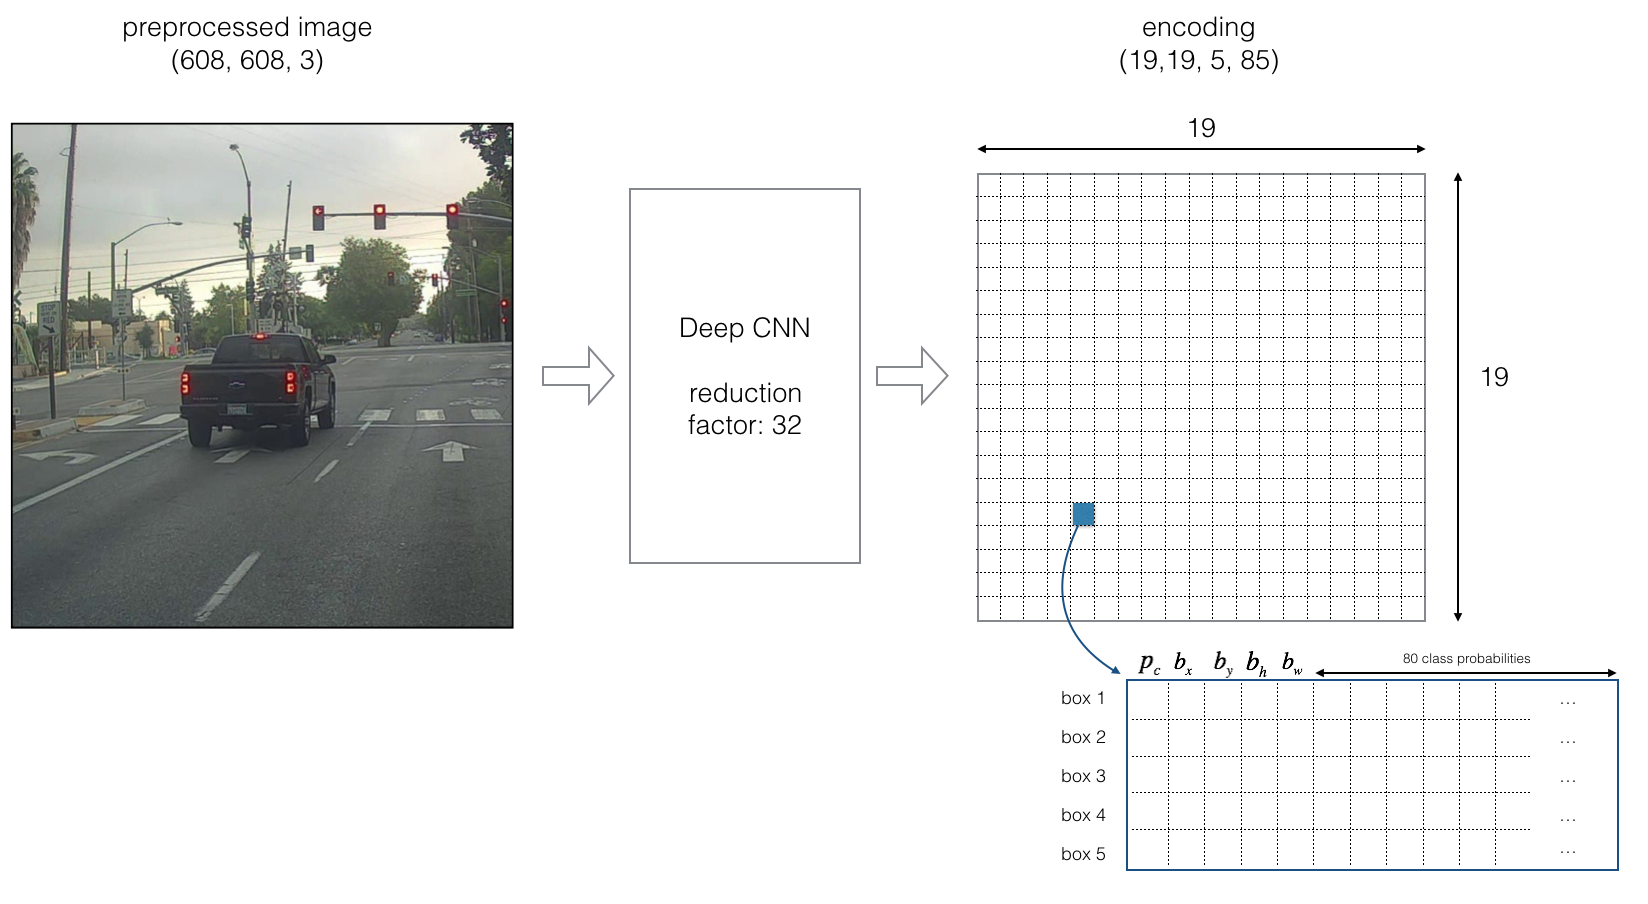</center>

- The YOLO architecture takes therefore a batch of images of shape $(m, 608, 608, 3)$ and encodes it into an activation volume of shape $(m, 19, 19, 5, 85)$.

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

For simplicity, the last two last dimensions of the encoded tensor $(19, 19, 5, 85)$ are flattened for the following figure, so the output of the network is $(19, 19, 425)$ (without the batch information).

<center>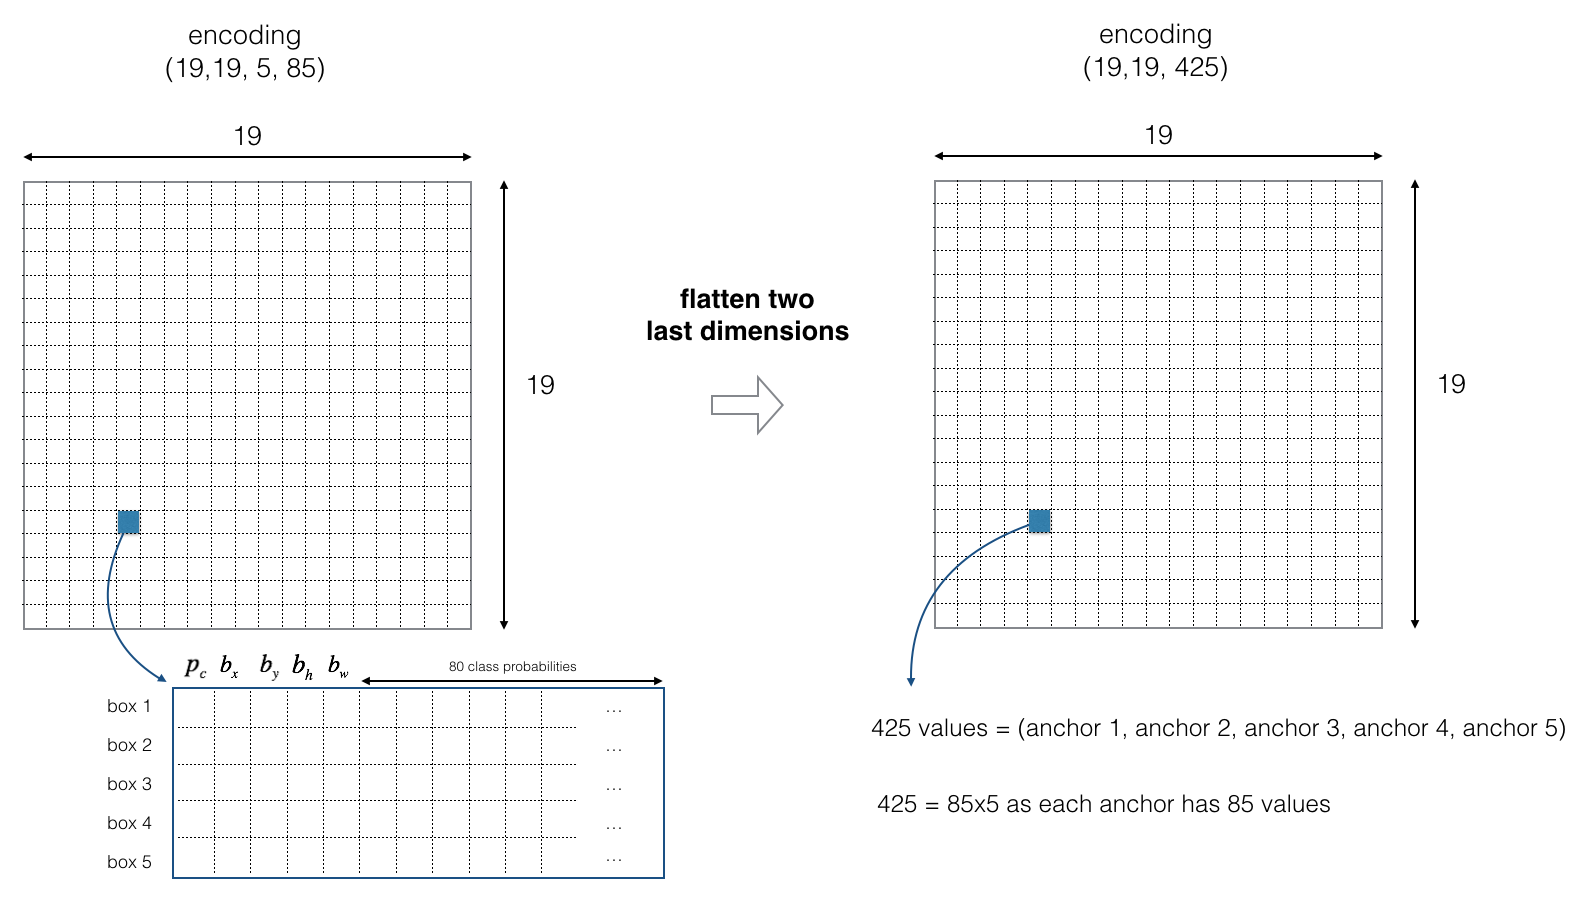</center>

**Class scores:**
Now, for each anchor box (of each cell), the following element-wise product is computed and a probability extracted that denotes if the box contains a certain class. 
- The class score is $score_{c,i} = p_{c} \times c_{i}$, which is the probability $p_{c}$ that there is an object in the anchor box times the probability that the object is of a certain class $c_{i}$.

**Example:**
* Let assume that for box 1 (cell 1), the probability that an object exists is $p_{1}=0.60$.  So there's a 60% chance that an object exists in box 1 (cell 1).  
* The probability that the object is of class '3' (e.g. a car) is $c_{3}=0.73$.  
* The score for box 1 ($p_1$) and for class '3' ($c_3$) is $score_{1,3}=0.60 \times 0.73 = 0.44$.  
* In the same way, all the scores for the 80 classes in box 1 are calculated, and if the score for class 3 (car) is the maximum, the score $0.44$ and the class '3' are assigned to box 1.

<center>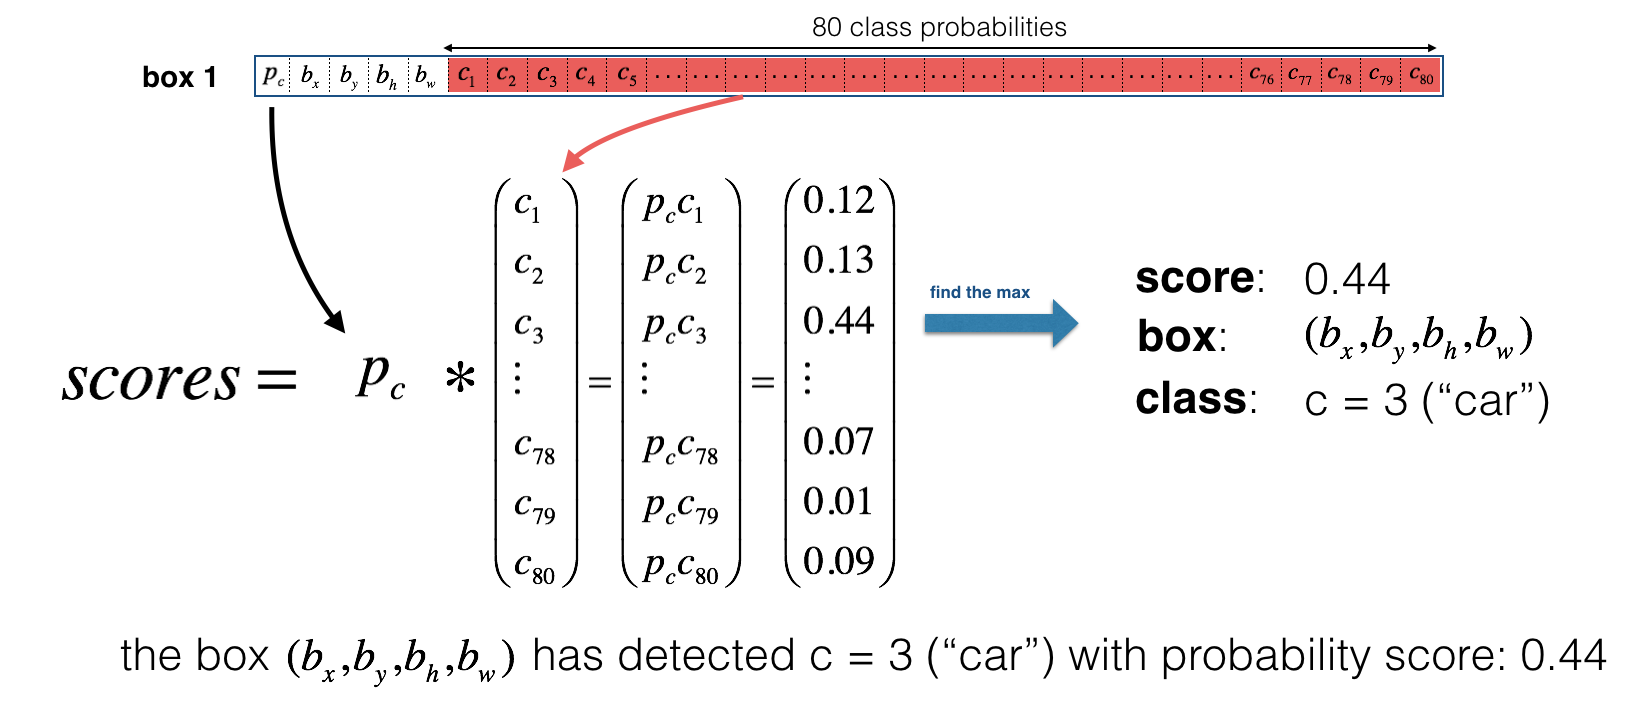</center>

**Visualizing classes:**
In the following figure, one way to visualize what YOLO is predicting on an image is given:
- For each of the 19x19 grid cells, find the maximum of the probability scores by taking the maximum across the 80 classes, and the maximum for each of the 5 anchor boxes).
- Color that grid cell according to what object that grid cell considers the most likely class.

Each one of the 19x19 grid cells is colored according to which class has the largest predicted probability in that cell:

<center> 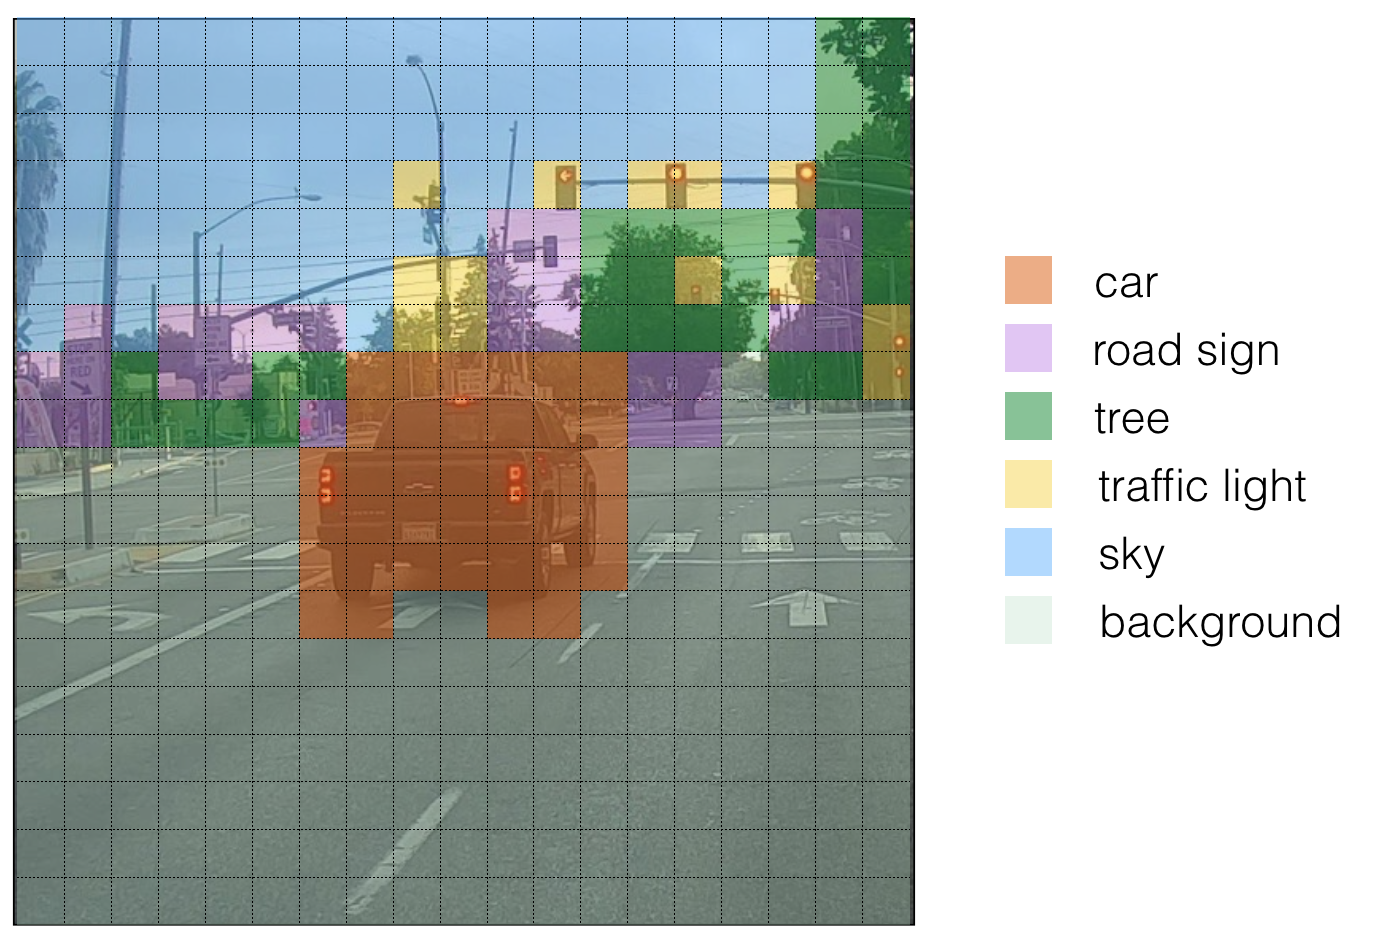 </center>
  
Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm. 

**Visualizing bounding boxes:**

Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<center>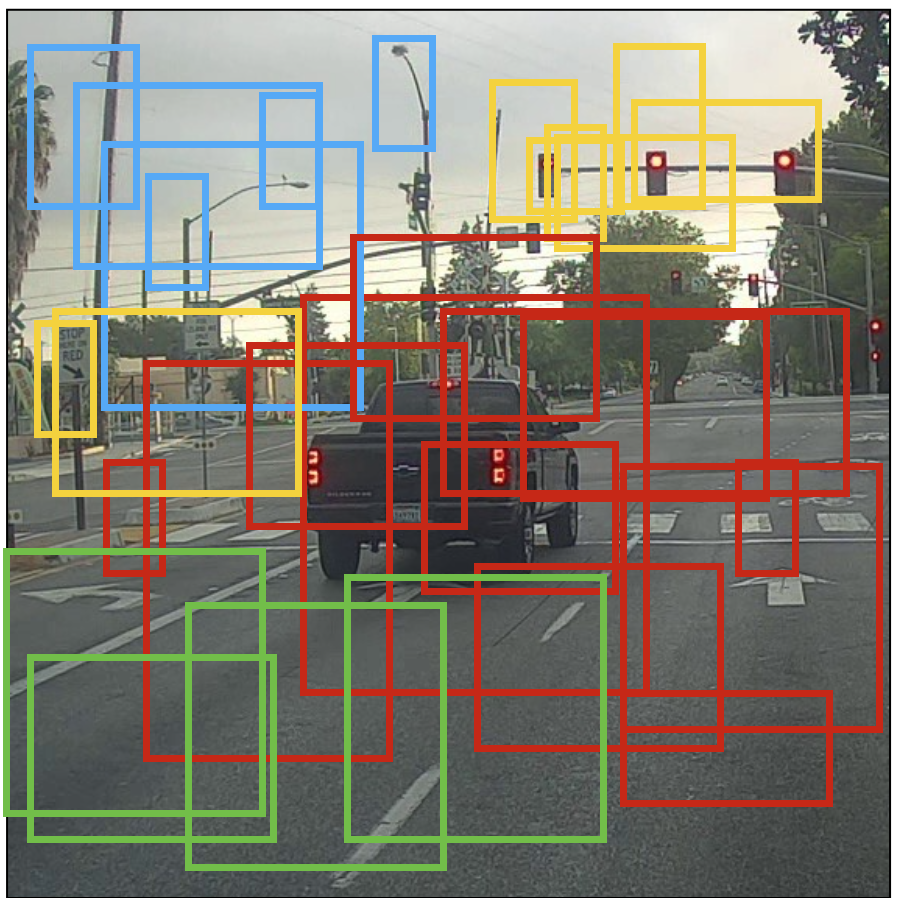</center>

Each cell gives five bounding boxes. In total, the model predicts 19x19x5 = 1805 bounding boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. But please note that these bounding boxes are not the final ones, but just a few examples, since the bounding boxes also have to go through a non-maximum suppression.

## Car Detection with YOLO v3

To make use of YOLO, you have several options. One is the TensorFlow 2 implementation [yolov3-tf2](https://github.com/zzh8829/yolov3-tf2) of YOLO v3.

The following command installs YoloV3-TF2 directly from it's GitHub repository.

In [3]:
import sys

!{sys.executable} -m pip install git+https://github.com/zzh8829/yolov3-tf2.git@master

  Cloning https://github.com/zzh8829/yolov3-tf2.git (to revision master) to /tmp/pip-req-build-8wehschg
  Running command git clone --filter=blob:none --quiet https://github.com/zzh8829/yolov3-tf2.git /tmp/pip-req-build-8wehschg
  Resolved https://github.com/zzh8829/yolov3-tf2.git to commit 2784050f2fc1ff060f4c8b3ac2db231370569aa8
  Preparing metadata (setup.py) ... done


To use YoloV3-TF2, we need the following files:

- **yolov3.weights** - These are the pre-trained weights provided by the author of YOLO.
- **coco.names** - The names of the 80 items that the **yolov3.weights** neural network was trained to recognize.
- **yolov3.tf** - The YOLO weights converted to a format that TensorFlow can use directly.

These are located at the ususal location `~/coursematerial/GIS/DeepLearning/YOLO`. (You do **not** need to copy these files in your working directory.)

In [4]:
from pathlib import Path

ROOT = str(Path.home()) + r'/coursematerial/GIS/DeepLearning/YOLO/'

The provided weights of YOLO is from training with the [Common Objects in Context (COCO)](https://arxiv.org/abs/1405.0312) dataset, which contains images labeled into 80 different classes. Since the weights provided by the original implementation of YOLO is not directly compatible with TensorFlow, the YOLO weights that we use have been convert into a TensorFlow compatible format. 

**We will not train the YOLO network ourselves, as this would take considerable time and resources.**

(YOLO was also adapted for mobile devices by creating the YOLO Tiny pre-trained weights that use a much smaller convolutional neural network and still achieve acceptable levels of quality. Though YoloV3-TF2 can work with either YOLO Tiny or regular YOLO we are not using the tiny weights for this tutorial.)

In [5]:
import os

filename_classes =  os.path.join(ROOT,'coco.names')

filename_converted_weights = os.path.join(ROOT,'yolov3.tf')

Now that we have all of the files needed for YOLO, we are ready to use it to recognize components of an image.

## Predictions with YOLO

The initialization of the YoloV3-TF2 library consists of three steps.  First, it is essential to import all of the needed packages for the library.  Next, the Python program must define all of the YOLO configurations through the Keras flags architecture. The Keras flag system primarily works from the command line. But we work in a notebook environment and we must deal with it in another way. Luckily, the flag system also allows configuration programmatically in an application.  For this example, we configure the YOLO package programmatically.

In [6]:
#from absl import app, flags, logging
from absl import flags
from absl.flags import FLAGS


# Flags are used to define several options for YOLO.
flags.DEFINE_string('classes', filename_classes, 'path to classes file')
flags.DEFINE_string('weights', filename_converted_weights, 'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
FLAGS([sys.argv[0]])


['/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py']

**It is important to understand that Keras flags can only be defined once. Running above cell twice gives you errors.** 

If you are going to classify more than one image, make sure that you do not define the flags another time.

The following code initializes a YoloV3-TF2 classification object. The weights are loaded, and the object is ready for use with the **yolo** variable. It is not necessary to reload the weights and obtain a new **yolo** variable for each classification.

There is also a slim version of YOLO implemented in YoloV3-TF called `YoloV3Tiny`, which you could also import and use, e.g., for mobile devices.

In [7]:
from yolov3_tf2.models import YoloV3

yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
print('Weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
print('Classes loaded')

2024-01-21 17:48:15.269753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14744 MB memory:  -> device: 7, name: Quadro RTX 5000, pci bus id: 0000:e1:00.0, compute capability: 7.5


Weights loaded
Classes loaded


Next, we obtain an image to classify. For this example, the program loads an image from the coursematerial folder with the `read_file()` function of TensorFLow. YoloV3-TF2 expects that the image is in the format of a NumPy array. An image file, such as JPEG or PNG, is therefore converted into this raw NumPy format by calling the TensorFlow `decode_image()` function. YoloV3-TF2 can obtain images from other sources, so long as the program first decodes them to raw NumPy format. 

Images are provided in the `coursematerial/GIS/DeepLearning/YOLO/images` folder that you can directly access.

In [8]:
image =  os.path.join(ROOT, r'images/0035.jpg')

content = tf.io.read_file(image)

img_raw = tf.image.decode_image(content, channels=3)

img_raw.shape

TensorShape([720, 1280, 3])

At this point, we increase the dimension of the single image to have a batch of one image. Then we pre-process the image with `transform_images()`, so that it has the expected size.

In [9]:
import tensorflow as tf
from yolov3_tf2.dataset import transform_images

print(img_raw.shape)

img = tf.expand_dims(img_raw, 0)

print(img.shape)

img = transform_images(img, FLAGS.size)

print(img.shape)

(720, 1280, 3)
(1, 720, 1280, 3)
(1, 416, 416, 3)


All there is to do is to set the confidence score threshold to 50%. Any bounding boxes with a confidence below this value is not returned by YOLO. Then, we classify the image with the `yolo´ object. 

**Note that prediction time for your first image might take some time. But the next images take much less time.**

In [10]:
FLAGS.yolo_score_threshold = 0.5

boxes, scores, classes, nums = yolo(img)

print(boxes.shape)
print(scores.shape)
print(classes.shape)
print(nums.shape)

2024-01-21 17:48:18.126281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


(1, 100, 4)
(1, 100)
(1, 100)
(1,)


Note that the `yolo` class returns everything as TensorFlow tensor, where the first dimension (in our example) is always one as there is one image in the input batch. That is the reason you have to use the index operator `[]` to address the data for the first image with index 0 (classes[0]).

In [11]:
print(f'Classes:\n {classes[0]}')

Classes:
 [2 2 2 2 9 2 9 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


It is important to note that the `yolo` class instantiated here is a callable object, which means that it can fill the role of both an object and a function. Acting as a function, `yolo` returns three arrays of `boxes`, `scores`, and `classes` that are of the same length (2nd dimension).  The function returns all objects found with a score above the minimum threshold. Additionally, the `yolo` function object returns an array `nums`. The first element of this array specifies how many objects YOLO found with a score above the specified threshold.

- `boxes` - the bounding boxes for each of the objects detected in the image sent to YOLO.
- `scores` - the confidence for each of the objects detected.
- `classes` - an array index to the classes for each of the items. These indices relate to the class names of COCO such as "person" or "dog".
- `nums` - the number of objects detected (above threshold).

You will notice that there are more values in the `classes` tensor than `nums` returned.

In [12]:
print(nums[0].numpy())

11


But the score is 0.0 for all objects with index `nums` or higher.

In [13]:
print(f'Scores:\n {scores[0]}')

Scores:
 [0.9752266  0.9734596  0.97118604 0.8752884  0.8288038  0.7873584
 0.7408601  0.7306507  0.6988236  0.57084346 0.5122415  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.    

The following code prints the objects detected above the threshold.

In [14]:
import numpy as np

for i in range(nums[0]):
    cls = class_names[int(classes[0][i])]
    score = np.array(scores[0][i])
    box = np.array(boxes[0][i])
    print(f"{cls:<15} {score:.4f}   {box}")

car             0.9752   [0.85159826 0.38445    0.9349165  0.43654755]
car             0.9735   [0.14485349 0.43593648 0.263799   0.5732367 ]
car             0.9712   [0.35858774 0.4196343  0.39672506 0.46908274]
car             0.8753   [0.39585105 0.40683648 0.42201695 0.44522098]
traffic light   0.8288   [0.41312698 0.20107716 0.42905113 0.25042975]
car             0.7874   [0.42400885 0.4033859  0.43912542 0.42414388]
traffic light   0.7409   [0.6407887  0.13490203 0.6727749  0.23047975]
car             0.7307   [0.4656158  0.39837793 0.47824425 0.41458377]
car             0.6988   [0.44348857 0.40042028 0.4567546  0.41762176]
traffic light   0.5708   [0.3151647  0.33275965 0.3237512  0.35236093]
car             0.5122   [0.7261955  0.379485   0.831206   0.45465505]


Note that the bounding boxes are given relative to the image with values between 0.0 and 1.0.

The following cell plots the input image and the objects detected above the threshold as bounding boxes. YoloV3-TF2 includes a function named `draw_outputs()` that visualizes the detected objects. The following image shows the output of this function.

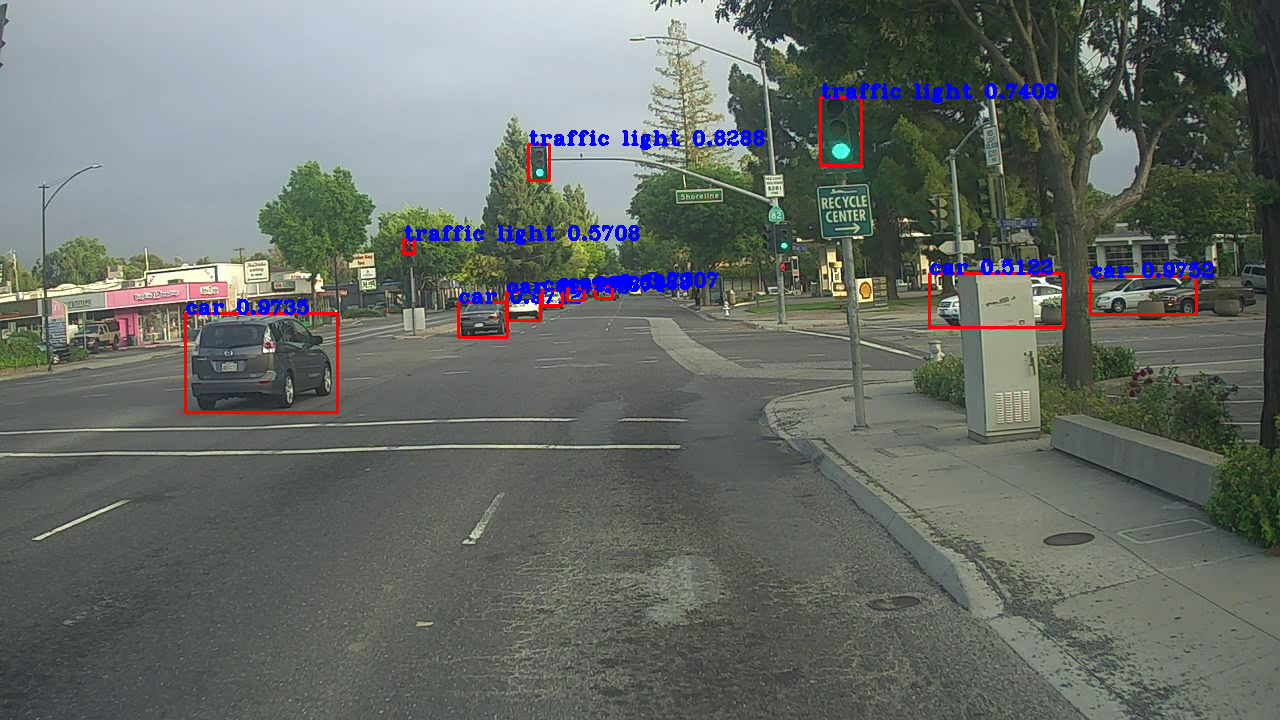

In [15]:
from yolov3_tf2.utils import draw_outputs
from PIL import Image

img = img_raw.numpy()

img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

display(Image.fromarray(img, 'RGB'))

## What now?
- Try a different image (maybe one with different objects)!
- Use a different score thresholds. What happens?
- Take a picture on some street and use YOLO to detect the objects. Did that work?
